In [2]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab
from scipy import stats

from  qgrid import show_grid as show 
from datetime import datetime

testname="test2"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]
# sensors.create_index({timestamp:1})

In [4]:
def get_times(targetname,source=db["testcases"+testname]):
    x= list(db["testcases"+testname].find({'name':targetname}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(targetname , source=db["sensor"+testname]):
    times=get_times(targetname)
    df = pd.DataFrame.from_dict(list(sensors.find({'timestamp' :{'$gte':times['begin'],'$lte':times['end']}})))
    result=df[df.target== targetname][["_id","rapl","timestamp"]]
    system=df[df.target== "system"] 
    result["rapl"]=result.apply(lambda row :math.ldexp(  system[system.timestamp==row['timestamp']].rapl.iloc[0]['0']['38']['RAPL_ENERGY_PKG'],-32), axis=1)
#     result['timestamp']= result.apply(lambda row :int(row['timestamp'].timestamp()),axis=1)
    return result

def calculate_energy(targetname) : 
    
    times=get_times(targetname)
    target=calculate_power(targetname)
    warmup = target[(target.timestamp >= times['warmup']) & (target.timestamp < times['execution']) ].loc[:,"rapl"].sum() 
    execution = target[(target.timestamp >= times['execution']) ].loc[:,"rapl"].sum() 
    return {'warmup':warmup,'execution': execution} 

def get_recap(target):
    energy=calculate_energy(target['name'])
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy['warmup'] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy['execution']}

In [3]:
def get_times(target,source=db["testcases"+testname]):
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    df = pd.DataFrame.from_dict(list(sensors.find({'timestamp' :{'$gte':times['begin'],'$lte':times['end']}})))
#     print(times)
#     return 
    result=df[df.target== times['name']][["_id","rapl","timestamp"]]
    system=df[df.target== "system"] 
    result["rapl"]=result.apply(lambda row :math.ldexp(  system[system.timestamp==row['timestamp']].rapl.iloc[0]['0']['38']['RAPL_ENERGY_PKG'],-32), axis=1)
#     result['timestamp']= result.apply(lambda row :int(row['timestamp'].timestamp()),axis=1)
    return result

def calculate_energy(times) : 
    target=calculate_power(times)
    warmup = target[(target.timestamp >= times['warmup']) & (target.timestamp < times['execution']) ].loc[:,"rapl"].sum() 
    execution = target[(target.timestamp >= times['execution']) ].loc[:,"rapl"].sum() 
    return {'warmup':warmup,'execution': execution} 

def get_recap(target):
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy['warmup'] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy['execution']}

In [4]:
regx = re.compile(".*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
data = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
    
data=pd.DataFrame.from_dict(data)
show(data)
# data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

(0.9538120627403259, 0.10261337459087372)


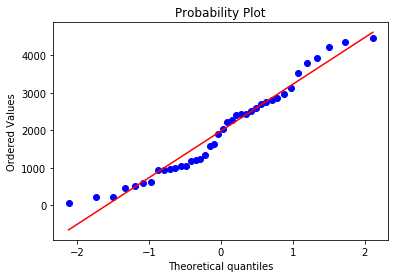

In [59]:
x=data['execution energy'].iloc[0:]
print(stats.shapiro(x))
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

<IPython.core.display.Javascript object>


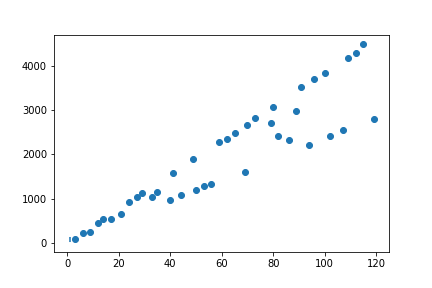

In [70]:
%matplotlib notebook 
pyplot.scatter(data['warmup time'],data['warmup energy'])

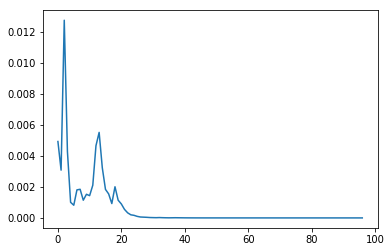

In [14]:
from matplotlib import pyplot
%matplotlib inline 
l=[stats.shapiro(data['execution '].iloc[0:x])[1] for x in range(3,100)]
pyplot.plot(l)

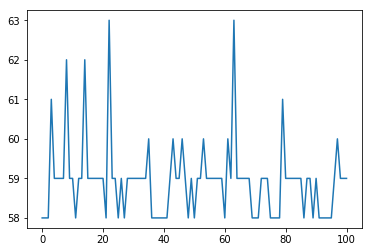

In [7]:
pyplot.plot(data['warmup time'])

In [77]:
# pyplot.violinplot(data['warmup time'])
pyplot.violinplot(data['execution time'])


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f375444b470>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3757fed6d8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f375444beb8>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f375444ba58>}

In [37]:
stats.mstats.kruskalwallis(list(data['execution time']),list(data['execution energy']))

KruskalResult(statistic=154.60956150163426, pvalue=1.7041869737618457e-35)

0     58
1     58
2     58
3     61
4     59
5     59
6     59
7     59
8     62
9     59
10    59
11    59
12    62
13    59
14    59
15    59
16    59
17    59
18    59
19    58
20    63
21    59
22    59
23    58
24    59
25    58
26    59
27    59
28    59
29    59
      ..
69    58
70    59
71    59
72    59
73    58
74    58
75    58
76    58
77    61
78    59
79    59
80    59
81    59
82    59
83    59
84    58
85    59
86    59
87    58
88    59
89    58
90    58
91    58
92    58
93    58
94    59
95    60
96    59
97    59
98    59
Name: warmup time, Length: 99, dtype: int64

In [10]:
regx = re.compile("tommtiv1int2.*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))

In [4]:
regx = re.compile(".*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))

In [6]:
times

,_id,begin,end,execution,name,warmup
0,5be1cf58e9352351327a5657,1541525318,1541525336,1541525324,testo1,1541525318
1,5be1d183e935235270cbdf75,1541525872,1541525891,1541525879,tommtiv1int1,1541525873
2,5be1d1aae93523543a273395,1541525911,1541525930,1541525918,tommtiv1int3,1541525912
3,5be1d1bee935235540d436e0,1541525931,1541525950,1541525937,tommtiv1int4,1541525932
4,5be1d1d1e9352356296eeea5,1541525950,1541525969,1541525957,tommtiv1int5,1541525951
5,5be1d1e5e93523570fcf2f49,1541525970,1541525989,1541525977,tommtiv1int6,1541525971
6,5be1d1f8e9352357f3811bcf,1541525989,1541526008,1541525996,tommtiv1int7,1541525990
7,5be1d20ce9352358dc141cf0,1541526009,1541526028,1541526015,tommtiv1int8,1541526010
8,5be1d21fe9352359bfc59207,1541526028,1541526047,1541526035,tommtiv1int9,1541526029
9,5be1d233e935235aa09d6ac0,1541526048,1541526067,1541526054,tommtiv1int10,1541526048
